# Predicting Daily Market Movements with QDA
This experiment uses Quadratic Discriminant Analysis (QDA), a classification method, to attempt to predict the directionality of daily market returns. This experiment starts by analyzing potential predictors and their relations with daily market movements. Data is then acquired and cleaned using Yahoo Finance; the market benchmark is SPY, an ETF tracking the S&P 500 index. Metrics are computed to determine the viability of the model, providing insghts into the model's fitting and performance. The model is then tested on in-sample and out-of-sample data using cross-validation to determine the model's performance. To conclude the experiment, the strategy is simulated to see how the model would have performed historically.

In [168]:
# File imports
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import ta

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from scipy.stats import normaltest
from scipy.linalg import pinv
from scipy.stats import chi2

# Import ISLP-Specific Functions/Classes
from ISLP import confusion_table
from ISLP.models import(
    ModelSpec as MS
)

# Import settings
plt.style.use('ggplot')

### 1. Assessing Predictors and Responses
The predictors used for the QDA model are specified below. The predictors are based on the market's price, volume, trend and momentum.<br>
1. Lagged returns keep the recent returns in "memory"
2. Lagged volumes keep the recent volume in "memory"
3. Relative strength index to measure the magnitude of recent price changes
4. Moving average to measure the trend of the price

In [169]:
# Download the data
t_data = yf.download('^GSPC', start='1980-01-01', interval='1d', auto_adjust=False)

BASE_COLS = ['Close', 'Volume', 'Returns', 'Direction']

# Re-format the yahoo finance data
data = pd.DataFrame()
data['Close'] = t_data['Close']
data['Volume'] = t_data['Volume']

# Calculate the daily returns
data['Returns'] = data['Close'].pct_change()

# Return predictors
data['Ret_Lag1'] = data['Returns'].shift(1)
data['Ret_Lag2'] = data['Returns'].shift(2)
data['Ret_Lag3'] = data['Returns'].shift(3)
data['Ret_Lag4'] = data['Returns'].shift(4)
data['Ret_Lag5'] = data['Returns'].shift(5)

# Volume predictors
data['Avg_Volume'] = data['Volume'].rolling(window=14).mean()

# Momentum predictors
data['RSI'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()

# Trend predictors
data['SMA'] = data['Close'].rolling(window=10).mean()

# Remove the lookahead bias from the rolling() function
data['Avg_Volume'] = data['Avg_Volume'].shift(1)
data['RSI'] = data['RSI'].shift(1)
data['SMA'] = data['SMA'].shift(1)

# Clean the data
data.dropna(axis=0, inplace=True)

# Label the return data to their respective classes (K=2)
data['Direction'] = np.where(data['Returns'] > 0, 'Up', 'Down')

# Data to use for fitting additional QDA models
test_data = data.copy()

[*********************100%***********************]  1 of 1 completed


In [170]:
# Seperate the predictor columns
predictor_columns = data.columns.drop(['Returns', 'Direction', 'Volume'])

# Calculate the correlations between the predictors and the daily returns
for col in data.columns:
    if col not in BASE_COLS:
        correlation = np.corrcoef(data['Returns'], data[col])[0][1]

        print(f'Correlation (Returns, {col}) = {correlation}')

Correlation (Returns, Ret_Lag1) = -0.05395894176394698
Correlation (Returns, Ret_Lag2) = -0.014378679484851912
Correlation (Returns, Ret_Lag3) = -0.012767693648092734
Correlation (Returns, Ret_Lag4) = -0.031932046535746016
Correlation (Returns, Ret_Lag5) = -0.005122481815502385
Correlation (Returns, Avg_Volume) = -0.0008339079977307243
Correlation (Returns, RSI) = -0.02891052831224497
Correlation (Returns, SMA) = -0.004109861940956252


The lagged returns, average volume, and simple moving average, show almost no correlation to the current day's return. The relative strength index and the price/SMA ratio have some correlation to the daily returns. Because the QDA model relies on the assumption that each class's predictor has independent covariance matrices, further collinearity tests must be conducted to determine if the response is collinear with the predictors.

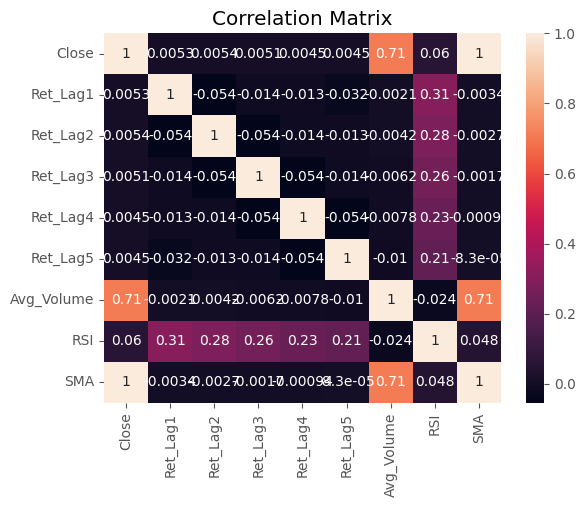

In [171]:
# Plot the correlation matrix heat map of the predictors
corr = data[predictor_columns].corr()
sns.heatmap(corr, annot=True)
plt.title('Correlation Matrix')
plt.show()

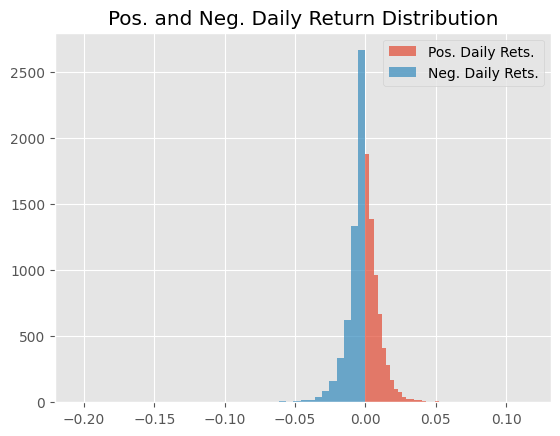

Number of Positive Daily Returns: 6095 | 53.399334151042574%
Number of Negative Daily Returns: 5319 | 46.600665848957426%


In [172]:
# Extract the positive and negative daily returns
positive_rets = data['Returns'][data['Returns'] > 0]
negative_rets = data['Returns'][data['Returns'] <= 0]

# Plot the distributions of the positive and negative daily returns
plt.hist(positive_rets, bins=40, alpha=0.7, label='Pos. Daily Rets.')
plt.hist(negative_rets, bins=40, alpha=0.7, label='Neg. Daily Rets.')
plt.title('Pos. and Neg. Daily Return Distribution')
plt.legend()
plt.show()

print(f'Number of Positive Daily Returns: {len(positive_rets)} | {(len(positive_rets) / len(data)) * 100}%')
print(f'Number of Negative Daily Returns: {len(negative_rets)} | {(len(negative_rets) / len(data)) * 100}%')

From the distrubution above, a dumb model of always predicting "Up" would achieve a success rate of 53.4%. This is the benchmark for the QDA model.

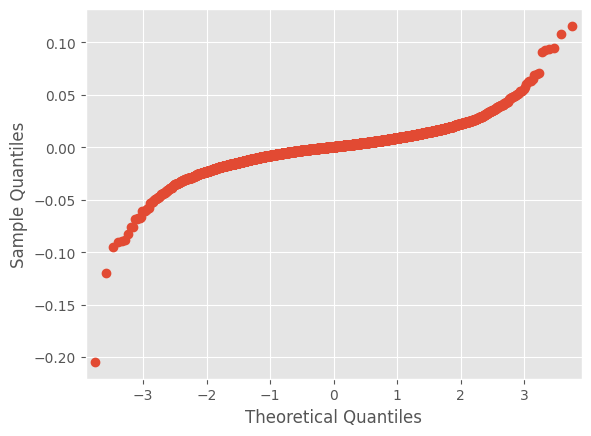

In [173]:
# Q-Q Plot of daily returns
sm.qqplot(data['Returns'])
plt.show()

Observing the Q-Q Plot, the pronounced S-curve of the plot indicates that the distribution of daily returns is either skewed or has different tails compared to the normal distribution. As seen in the distribution of daily returns, the distribution is left-skewed, with more positive daily returns. Rougly 54% of the daily returns are positive and 46% of the daily returns are negative. By inspection, the daily return distribution appears to have fat tails with some daily returns around +/-5%. Because QDA assumes predictors are drawn from a normal distribution, the code below tests the predictors within each class for normality.<br><br>
Null Hypothesis (H0):        Data is a normal distribution<br>
Alternative Hypothesis (Ha): Data is not a normal distribution

In [174]:
# Test the predictors for normality
alpha = 0.01

# Seperate the predictor columns from the data
predictor_columns = data.columns.drop(BASE_COLS)

# Group the data into Up and Down classes
grouped = data.groupby('Direction')
for name, group in grouped:
    print(f'Predictor Distributions ({name}) =================')

    for predictor in predictor_columns:
        stat, pval = normaltest(group[predictor])

        # If the p-value is > alpha, reject the null hypothesis
        if pval <= alpha:
            print(f'95% confident that: {predictor} is normally distributed.')
        else:
            print(f'95% confident that: {predictor} is not normally distributed.')

Predictor Distributions (Down) =================
95% confident that: Ret_Lag1 is normally distributed.
95% confident that: Ret_Lag2 is normally distributed.
95% confident that: Ret_Lag3 is normally distributed.
95% confident that: Ret_Lag4 is normally distributed.
95% confident that: Ret_Lag5 is normally distributed.
95% confident that: Avg_Volume is normally distributed.
95% confident that: RSI is normally distributed.
95% confident that: SMA is normally distributed.
Predictor Distributions (Up) =================
95% confident that: Ret_Lag1 is normally distributed.
95% confident that: Ret_Lag2 is normally distributed.
95% confident that: Ret_Lag3 is normally distributed.
95% confident that: Ret_Lag4 is normally distributed.
95% confident that: Ret_Lag5 is normally distributed.
95% confident that: Avg_Volume is normally distributed.
95% confident that: RSI is normally distributed.
95% confident that: SMA is normally distributed.


We can see that all of the predictors appear to be a normal distribution at the 99% confidence interval.

In [175]:
# Seperate the predictors and the response
X = MS(predictor_columns).fit_transform(data)
y = data.Direction == 'Up'

In [176]:
# Check collinearity using the variance inflation factor (VIF)
vifs = [VIF(X, i) for i in range(1, X.shape[1])]
vifs = pd.DataFrame({'VIF' : vifs}, index=X.columns[1:])

print(vifs)

                 VIF
Ret_Lag1    1.193954
Ret_Lag2    1.178286
Ret_Lag3    1.152827
Ret_Lag4    1.126806
Ret_Lag5    1.102040
Avg_Volume  2.027303
RSI         1.648189
SMA         2.034508


The variance inflation factors, which check foir multicollinearity, are all below 5, suggesting minimal collinearity between the predictors. Becasue the VIFs are below 5, it indicates that there is minimal collinearity and each predictor has its own set of "predictive" information.

In [177]:
# Box's M Test
def box_m_test(X, y):
    # Determine the classes and features
    classes = np.unique(y)
    n_total = len(X)
    n_features = X.shape[1]

    group_covs = []
    group_sizes = []
    pooled_cov = np.zeros((n_features, n_features))

    # Calculate the covariances across each class
    epsilon = 1e-6 # Apply regularization to stabilize covariance matrices
    for cls in classes:
        X_cls = X[y == cls]
        n_cls = X_cls.shape[0]
        cov_cls = np.cov(X_cls, rowvar=False) + epsilon * np.identity(n_features)
        group_covs.append(cov_cls)
        group_sizes.append(n_cls)
        pooled_cov += (n_cls - 1) * cov_cls

    pooled_cov /= (n_total - len(classes))
    pooled_cov += epsilon * np.identity(n_features)

    sign_pooled, logdet_pooled = np.linalg.slogdet(pooled_cov)
    if sign_pooled <= 0:
        raise ValueError("Pooled covariance matrix is not positive definite.")

    # Calculate Box's M Test statistic
    M = 0
    for i in range(len(classes)):
        sign_i, logdet_i = np.linalg.slogdet(group_covs[i])
        if sign_i <= 0:
            raise ValueError(f"Covariance matrix for class {classes[i]} is not positive definite.")

        n_i = group_sizes[i]
        term = (n_i - 1) * (np.log(np.linalg.det(pooled_cov)) - np.log(np.linalg.det(group_covs[i])))
        M += term

    # Apply the correlation factor to the test statistic
    c = ((2 * n_features**2 + 3 * n_features - 1) *
         (sum(1 / (np.array(group_sizes) - 1)) - 1 / (n_total - len(classes))))
    c /= (6 * (n_features + 1) * (len(classes) - 1))

    # Calculate the Chi-Squred stat and p-value
    chi2_stat = M * (1 - c)
    df = (n_features * (n_features + 1) / 2) * (len(classes) - 1)
    p_value = 1 - chi2.cdf(chi2_stat, df)

    return chi2_stat, p_value

chi2, pval = box_m_test(X, y)

print(f"Box's M Test Results ====================")
print(f"P-Value:               {pval}")
print(f"Chi-Squared Statistic: {chi2}")

Box's M Test Results ====================
P-Value:               0.0
Chi-Squared Statistic: 8551.423496444397


Box's M test tests the coivariance matrices within each response class. The p-value indicates that the predictors in each class have different covariance matrices, justifying the use of the Quadratic Discriminat Analysis model.

In [178]:
NON_PREDICTOR_COLS = 2 # Number of non-predictor columns
p = len(data.columns) - NON_PREDICTOR_COLS
n = len(data)

print(f'Ratio of predictors to observations: {p / n}')

Ratio of predictors to observations: 0.0008761170492377782


In [179]:
# Display the basic summary of the data
print(f'Predictor Data Set Shape: {X.shape}')
print(f'Class Distribution: \n{pd.Series(y).value_counts()}')

# NOTE: True is "Up" and False is "Down"

Predictor Data Set Shape: (11414, 9)
Class Distribution: 
Direction
True     6095
False    5319
Name: count, dtype: int64


In [180]:
TRAIN = 0.80
train_len = int(len(data) * TRAIN)

X_train, X_test = X[:train_len], X.iloc[-train_len:]
y_train, y_test = y[:train_len], y.iloc[-train_len:]
D = data.Direction
L_train, L_test = D[:train_len], D.iloc[-train_len:]

# Remove the intercept (set my the MS.fit_transform)
X_train = X_train.drop(columns='intercept')
X_test = X_test.drop(columns='intercept')

In [181]:
# Quadratic discriminant analysis (test data)
# Apply a regilarization parameter to the covariance matrices (like in Box's M test)
epsilon = 1e-4
qda = QDA(store_covariance=True, reg_param=epsilon)
qda.fit(X_train, L_train)

qda_predictions = qda.predict(X_test)

In [182]:
# Performance metrics
confusion_matrix = confusion_table(qda_predictions, L_test)
print(confusion_matrix)

prediction_rate = np.mean(qda_predictions == L_test)
training_error = np.mean(qda_predictions != L_test)

false_positive_rate = confusion_matrix.iloc[1, 0] / (confusion_matrix.iloc[0, 0] + confusion_matrix.iloc[1, 0])
false_negative_rate = confusion_matrix.iloc[0, 1] / (confusion_matrix.iloc[0, 1] + confusion_matrix.iloc[1, 1])

sensitivity = confusion_matrix.iloc[1, 1] / (confusion_matrix.iloc[0, 1] + confusion_matrix.iloc[1, 1])
specificity = confusion_matrix.iloc[0, 0] / (confusion_matrix.iloc[0, 0] + confusion_matrix.iloc[1, 0])

print('\nQDA: Test Model Performance ==========')
print(f'Prediction Rate:     {prediction_rate:.4f}')
print(f'Training Error:      {training_error:.4f}')
print(f'Model Sensitivity:   {sensitivity:.4f}')
print(f'Model Specificity:   {specificity:.4f}')
print(f'False Positive Rate: {false_positive_rate:.4f}')
print(f'False Negative Rate: {false_negative_rate:.4f}')

Truth      Down    Up
Predicted            
Down       1419  1545
Up         2807  3360

QDA: Test Model Performance ==========
Prediction Rate:     0.5234
Training Error:      0.4766
Model Sensitivity:   0.6850
Model Specificity:   0.3358
False Positive Rate: 0.6642
False Negative Rate: 0.3150


#### Results
The model correcly predicts the direction of the market only 52.34% of the time and incorrectly predict's the market's direction 47.66% of the time. This is a decrease from the baseline 53% indicating that a simple buy-and-hold strategy performs better than the QDA prediction model. Looking into the class-specific predictions, Up is correctly predicted over 68.50% of the time and Down is correctly predicted only 33.58% of the time. On average, the model performs better predicting Up compared to Down. Overall, the model's estimated test-error rate using a simple cross-validation is 47.66% which is lower than the market's baseline test error.

### 2. Cross-Validation
To better assess the best model's test error rate, LOOCV (leave-one-out cross-validation) will be used. Fitting n QDA models, where n is the number of observations in the data set, we can getter a better estimate of the model's performance compared to the simple validation set approach used above.

In [183]:
# Leave-One-Out Cross Validation
# Reload the data
data = test_data.copy()

errors = []
n = len(data)

for i in range(n):
    # Split training and test data
    test_data_ = data.iloc[[i]]                 # ith row only
    train_data = data.drop(index=data.index[i]) # Removed the ith row

    # Extract direction labels
    y_train = train_data['Direction']
    y_test = test_data_['Direction'].values[0]

    # Transform predictors
    X_train = MS(predictor_columns).fit_transform(train_data).drop(columns='intercept')
    X_test = MS(predictor_columns).fit_transform(test_data_).drop(columns='intercept')

    # Fit QDA and make prediction
    epsilon = 1e-4
    qda = QDA(store_covariance=True, reg_param=epsilon)
    qda.fit(X_train, y_train)

    prediction = qda.predict(X_test)

    # Record error
    errors.append(int(prediction[0] != y_test))

# Compute LOOCV error
estimated_error = np.mean(errors)
print(f'Estimated LOOCV Test Error: {estimated_error:.4f}')

Estimated LOOCV Test Error: 0.4702


Using the LOOCV method to estimate the test-error of the QDA model, it appears that the simple cross-validation approach slightly overestimated the test error. The LOOCV apprach estimates the test error of the model to be 47.02%, compared to the 47.66% estimated by the simple cross-validation approach above. From the LOOCV, we can conclude that the model is not viable for predicting daily market return directionality.

### 3. Historical Backtest Performance
To conclude the experiment, the model's historical performance will be simulated using a backtest. First, the QDA model will be fit on a historical training set. On each iteration (day) the model will be re-fit due to new data being observed. We know that the model underperforms a simple buy and hold strategy, thus we expect the total return of the QDA strategy to be less than the market's return.

In [184]:
# Reload the data
data = test_data.copy()

START_YEAR = '1990-01-01 00:00:00' # Year for starting the backtest

# Create the training set
train_data = data[data.index < START_YEAR]
market_data = data[data.index >= START_YEAR]

X_train = MS(predictor_columns).fit_transform(train_data).drop(columns='intercept')
y_train = train_data.Direction

# Train the initial QDA model
epsilon = 1e-4
qda = QDA(store_covariance=True, reg_param=epsilon)
qda.fit(X_train, y_train)

# Starting index of the backtest
start_idx = len(train_data)

returns = []
errors = []

for i in range(start_idx, len(data)):
    X_test = data.iloc[[i]]
    X_test = MS(predictor_columns).fit_transform(X_test).drop(columns='intercept')

    # Predict the current market direction using the trained QDA model
    qda_prediction = qda.predict(X_test)

    """
    * To determine the actual returns earned by the model, the predicted direction is
    * compared to the day's direction.
    *
    * 1. Prediction = 'Up' and Actual = 'Up', return = daily market return
    * 2. Prediction = 'Up' and Actual = 'Down', return = daily market return
    * 3. Prediction = 'Down' and Actual = 'Up', return = -1 * daily market return
    * 4. Prediction = 'Down' and Actual = 'Down', return = -1 * daily market return
    """
    if qda_prediction[0] == 'Up' and data.iloc[i]['Direction'] == 'Up':
        returns.append(data['Returns'].iloc[i])

    elif qda_prediction[0] == 'Up' and data.iloc[i]['Direction'] == 'Down':
        returns.append(data['Returns'].iloc[i])

    elif qda_prediction[0] == 'Down' and data.iloc[i]['Direction'] == 'Up':
        returns.append(-data['Returns'].iloc[i])

    else: # Down, Down
        returns.append(-data['Returns'].iloc[i])

    # Record the model errors
    errors.append(int(qda_prediction[0] != data.iloc[i]['Direction']))

    # Re-train the QDA model with the newly observed data
    new_train = data[0:i+1]
    newX_train = MS(predictor_columns).fit_transform(new_train).drop(columns='intercept')
    newY_train = new_train.Direction

    qda = QDA(store_covariance=True, reg_param=epsilon)
    qda.fit(newX_train, newY_train)

# Display model performance
print(f'Error Rate:      {np.mean(errors)}')
print(f'Prediction Rate: {(1 - np.mean(errors))}')

Error Rate:      0.4803370786516854
Prediction Rate: 0.5196629213483146


### Conclusion
In this experiment, I sought to see if a QDA model with return, volume, trend, and momentum predictors could accurately classify the direction of tomorrow's daily return. After inspection, the QDA model predicted the daily return over 50% of the time, but underperformed the simple buy and hold strategy. Further improvements can be made by experimenting with combinations of predictors or different predictors altogether. In summary, the QDA model underperformed the simple buy and hold market return.